# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyproj
from pysheds.grid import Grid
import seaborn as sns
import rasterio
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_palette('husl', 8)

# Create empty grid instance

In [3]:
grid = Grid()

# Read data as ndarrays

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [4]:
with rasterio.open('../data/n30w100_dir') as f:
    fdir = f.read().reshape(f.shape)
    
with rasterio.open('../data/n30w100_con/') as f:
    dem = f.read().reshape(f.shape)

# Specify flow direction values

In [5]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Compute accumulation

In [6]:
acc = grid.accumulation(fdir, dirmap=dirmap, inplace=False, nodata_in=0,
                        ignore_metadata=True)

# Delineate catchment

In [7]:
# Specify pour point (greatest accumulation)
y, x = np.unravel_index(np.argmax(acc), acc.shape)

# Delineate the catchment
catch = grid.catchment(data=fdir, x=x, y=y, dirmap=dirmap, inplace=False,
                       recursionlimit=15000, xytype='index', nodata_in=0,
                       ignore_metadata=True)

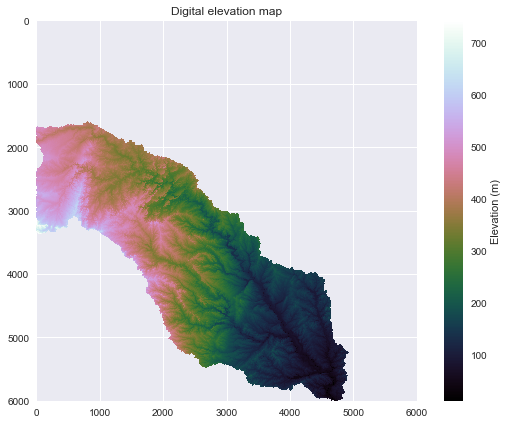

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(np.where(catch, dem, np.nan), cmap='cubehelix', zorder=1)
plt.colorbar(im, label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.tight_layout()

# Clip to catchment

In [9]:
nz_y, nz_x = np.nonzero(catch)
xmin, xmax = np.min(nz_x), np.max(nz_x)
ymin, ymax = np.min(nz_y), np.max(nz_y)
catch = catch[ymin:ymax, xmin:xmax]

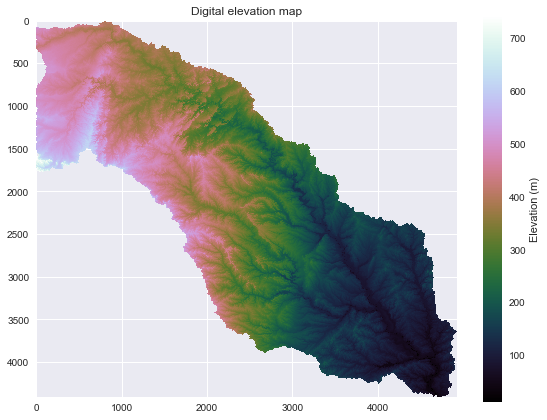

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(np.where(catch, dem[ymin:ymax, xmin:xmax], np.nan),
               cmap='cubehelix', zorder=1)
plt.colorbar(im, label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.tight_layout()

# Get flow accumulation in catchment

In [11]:
catch_acc = grid.accumulation(data=catch, dirmap=dirmap, inplace=False, nodata_in=0,
                              ignore_metadata=True)

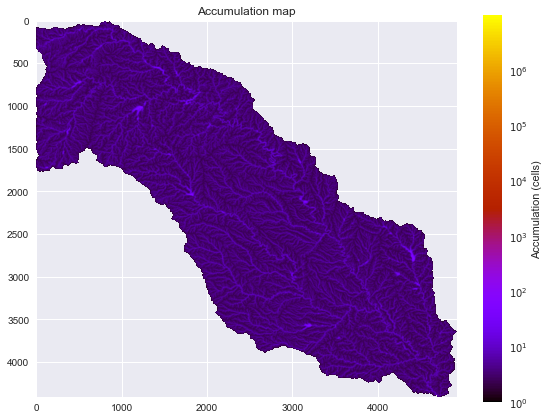

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(np.where(catch, (catch_acc + 1), np.nan), 
               cmap='gnuplot', interpolation='bicubic',
               norm=colors.LogNorm(1, catch_acc.max()),
               zorder=1)
plt.colorbar(im, label='Accumulation (cells)')
plt.grid(zorder=0)
plt.title('Accumulation map')
plt.tight_layout()

# Use different nodata value

In [13]:
catch[catch == 0] = -9999

catch_acc = grid.accumulation(data=catch, dirmap=dirmap, inplace=False, nodata_in=-9999,
                              ignore_metadata=True)

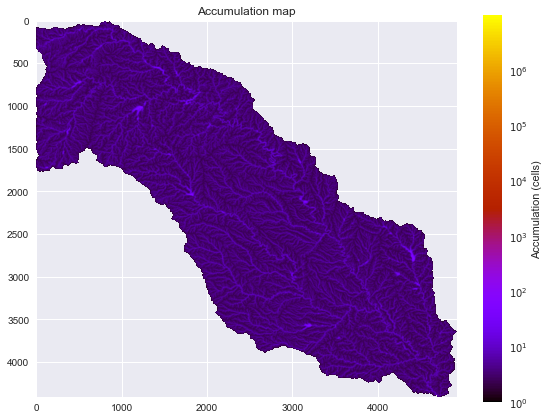

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(np.where(catch, (catch_acc + 1), np.nan), 
               cmap='gnuplot', interpolation='bicubic',
               norm=colors.LogNorm(1, catch_acc.max()),
               zorder=1)
plt.colorbar(im, label='Accumulation (cells)')
plt.grid(zorder=0)
plt.title('Accumulation map')
plt.tight_layout()